In [1]:
"""
This project was developed by Peter Chen, Rocky Duan, Pieter Abbeel for the Berkeley Deep RL Bootcamp, August 2017.
Bootcamp website with slides and lecture videos: https://sites.google.com/view/deep-rl-bootcamp/.

Code adapted from Stanford CS231N materials: http://cs231n.stanford.edu/
"""


# note to properly run this lab, you should execute all code blocks sequentially
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions

from collections import namedtuple, defaultdict, deque

import numpy as np

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

/home/jim/anaconda3/envs/gym35/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Introduction to Chainer

Chainer can be understood as Numpy plus the ability to record the computation graph of numerical operations to enable Automatic Differentiation. (Chainer actually also offers many other things; for example, a Numpy equivalent library that runs on GPU, but we will ignore them for now)

Let's illustrate how Chainer works by a simple 1D regression task.

Suppose we have observations from the following model $y = w x + b + \epsilon$ where $\epsilon \sim \mathcal{N}(0, 0.1)$ and the task is to estimate the linear model parameters $w, b$ from data.

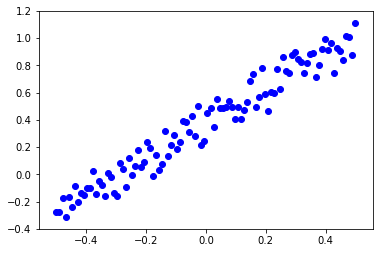

In [2]:
# first generate some observations
true_a = 1.3
true_b = 0.4
data_x = (np.arange(100) / 99.0 - .5).astype(np.float32) # Chainer assumes all the cpu computation is done in float32
data_y = (data_x * true_a + true_b + np.random.randn(*data_x.shape) * 0.1).astype(np.float32)
_ = plt.scatter(data_x, data_y, c='b')

Chainer provides an abstraction called `Link` that describe some computation and keeps track of parameters for it. For instance, a `Linear` link describes a linear map on input and keeps track of `w` and bias `b`.

In [4]:
model = L.Linear(in_size=1, out_size=1) # input is 1D data and output is also 1D data

# Chainer will randomly initialize `w` and `b` for us.
# we can take a look at their values
print("w:", model.W)
print("b:", model.b)

# model.W and model.b have type `chainer.Variable`, 
#   which is a wrapper around Numpy array
assert isinstance(model.W, chainer.Variable)

# operations that involve `chainer.Variable` will produce
#   `chainer.Variable` and this records the computation graph
var_result = model.W + 123 # some random computation
print("Operations on chainer.Variable: %s, type: %s" % (var_result, type(var_result)))

# the underlying numpy array can be accessed by `data` attribute
print("numpy arrays:", model.W.data, var_result.data)

w: variable W([[0.00018879]])
b: variable b([0.])
Operations on chainer.Variable: variable([[123.00019]]), type: <class 'chainer.variable.Variable'>
numpy arrays: [[0.00018879]] [[123.00019]]


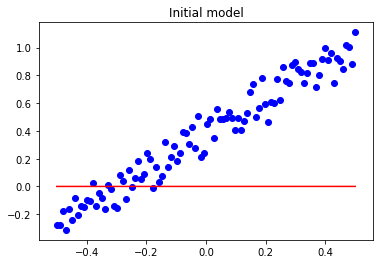

In [5]:
# A chainer link is a callable object. calling it performs the
#   forward computation. (in this case, it performs Wx + b)
model_y = model(data_x[:, None]) # chainer's link usually assumes input is [Batch Size, Input Dimension]
# `model_y` is a chainer variable so we use `.data` to access its numpy array for plotting

# we can plot the model's current fit in red. it should be terrible because we haven't trained it yet
_ = plt.plot(data_x, model_y.data[:,0], c='r')
_ = plt.scatter(data_x, data_y, c='b')
_ = plt.title("Initial model")

In [6]:
# now let's walk through how to perform forward computation
#  and use AD to get gradients

# first we clear the gradients that are stored in the model
model.cleargrads()
# as we have seen we can perform forward computation by calling the link
model_y = model(data_x[:, None])

# remember that `model_y` is a chainer variable. to operate on chainer variable
#    we will use functions from chainer.functions to operate on those objects.
loss = F.mean(F.square(model_y - data_y[:, None]))
# `loss` is a scalar chainer variable
assert isinstance(loss, chainer.Variable)
print("loss", loss)
# calculating gradients d loss /d params is as simple as
loss.backward()

# we can inspect the gradient of loss with respect to W
print("dloss/dW", model.W.grad)

loss variable(0.29198888)
dloss/dW [[-0.21909025]]


Now that we know how to calculate gradients, we can code up a simple loop to perform gradient descent to train this model:

(Hint: if you run into weird problems, maybe the state has been messed up and you can try re-runing all the code blocks from the beginning)

Itr 0 loss: variable(0.15111804)
Itr 25 loss: variable(0.00754209)
Itr 50 loss: variable(0.00748643)
Itr 75 loss: variable(0.00747114)


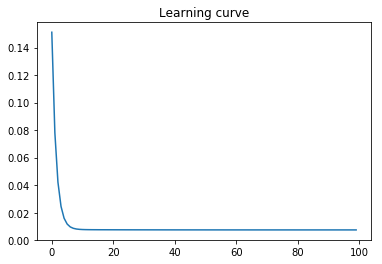

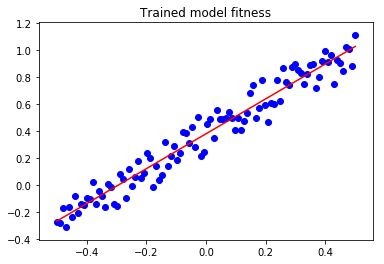

In [10]:
# now we can perform gradient descent to improve this model
model = L.Linear(in_size=1, out_size=1)
losses = []

for i in range(100):
    model.cleargrads()
    loss = F.mean(F.square(model(data_x[:, None]) - data_y[:, None]))
    losses.append(float(loss.data))
    ## *** YOUR CODE HERE TO PERFORM GRADIENT DESCENT ***
    ## Hint: you could access gradients with model.W.grad, model.b.grad
    ## Hint2: you could write data into a parameter with model.W.data[:] = some_numpy_array
    ## Hint3: if your model doesn't learn, remember to try different learning rates
    loss.backward()
    model.W.data[:] -= 0.15*model.W.grad
    model.b.data[:] -= 0.15*model.b.grad
    
    if i % 25 == 0:
        print("Itr", i, "loss:", loss)
plt.plot(np.array(losses))
plt.title("Learning curve")
plt.figure()
plt.plot(data_x, model(data_x[:, None])[:,0].data, c='r')
plt.scatter(data_x, data_y, c='b')
_ = plt.title("Trained model fitness")


## Train your first deep model

Now we have learned the basics of Chainer. We can use it to train a deep model to classify MNIST digits. We will train a model on the MNIST dataset because the dataset is small.

First we load the data and see what the images look like:

train[i][0] is the ith image that's flattened, and has shape: (784,)
train[i][1] is the ith image's label, such as: 3


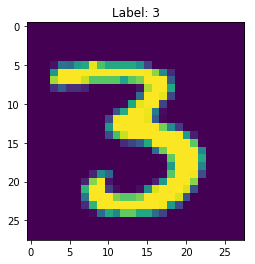

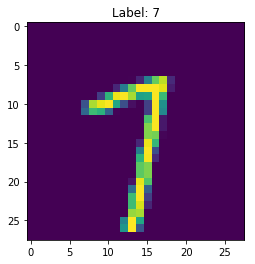

In [11]:
train, test = chainer.datasets.get_mnist()
# use train[data_point_index] to access data
print("train[i][0] is the ith image that's flattened, and has shape:", train[12][0].shape)
print("train[i][1] is the ith image's label, such as:", train[12][1])
# here we visualize two of them
plt.imshow(train[12][0].reshape([28, 28,]))
plt.title("Label: %s" % train[12][1])
plt.figure()
plt.imshow(train[42][0].reshape([28, 28,]))
_ = plt.title("Label: %s" % train[42][1])

Next we will provide some boilerplate code and train a linear classifier as an example:

In [12]:
def run(model, batchsize=16, num_epochs=2):
    
    optimizer = chainer.optimizers.Adam() # we will use chainer's Adam implementation instead of writing our own gradient based optimization
    optimizer.setup(model)
    
    stats = defaultdict(lambda: deque(maxlen=25))
    for epoch in range(num_epochs):
        train_iter = chainer.iterators.SerialIterator(train, batchsize, repeat=False, shuffle=True)
        test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)
        
        for itr, batch in enumerate(train_iter):
            xs = np.concatenate([datum[0][None, :] for datum in batch])
            ys = np.array([datum[1] for datum in batch])

            logits = model(xs)

            loss = F.softmax_cross_entropy(logits, ys)
            model.cleargrads()
            loss.backward()
            optimizer.update()
            
            # calculate stats
            stats["loss"].append(float(loss.data))
            stats["accuracy"].append(float((logits.data.argmax(1) == ys).sum() / batchsize))
            if itr % 300 == 0:
                print("; ".join("%s: %s" % (k, np.mean(vs)) for k, vs in stats.items()))

# try a simple linear model
run(L.Linear(None, 10))

accuracy: 0.0625; loss: 2.2968640327453613
accuracy: 0.88; loss: 0.5627782022953034
accuracy: 0.885; loss: 0.44412090361118317
accuracy: 0.925; loss: 0.3214197778701782
accuracy: 0.8925; loss: 0.42477931797504426
accuracy: 0.8875; loss: 0.39329455435276034
accuracy: 0.9075; loss: 0.3366357982158661
accuracy: 0.8925; loss: 0.41139505684375766
accuracy: 0.92; loss: 0.3018104186654091
accuracy: 0.9125; loss: 0.331228591799736
accuracy: 0.8975; loss: 0.33718644082546234
accuracy: 0.89; loss: 0.34411234825849535
accuracy: 0.915; loss: 0.3019589990377426
accuracy: 0.91; loss: 0.31041518956422803
accuracy: 0.92; loss: 0.3012539088726044
accuracy: 0.905; loss: 0.3384931644797325
accuracy: 0.8875; loss: 0.3796446615457535
accuracy: 0.9275; loss: 0.22186097770929336
accuracy: 0.9325; loss: 0.26869087606668474
accuracy: 0.935; loss: 0.2600890150666237
accuracy: 0.9225; loss: 0.2508661404252052
accuracy: 0.9275; loss: 0.24266562968492508
accuracy: 0.9275; loss: 0.3037196797132492
accuracy: 0.91; l

Next we will try to improve performance by training an MLP instead. A partial implementation is provided for you to fill in:

In [14]:
class MLP(chainer.Chain):

    def __init__(self, n_units, n_out):
        super(MLP, self).__init__()
        with self.init_scope():
            # the size of the inputs to each layer will be inferred
            self.l1 = L.Linear(None, n_units)  # n_in -> n_units
            self.l2 = L.Linear(None, n_units)  # n_units -> n_units
            self.l3 = L.Linear(None, n_out)  # n_units -> n_out

    def __call__(self, x):
        # *** YOUR CODE HERE TO BUILD AN MLP W/ self.l1, self.l2, self.l3 ***
        # 
        # Hint: you should make use of non-linearities / activation functions
        #     https://docs.chainer.org/en/stable/reference/functions.html#activation-functions
        #raise NotImplementedError()
        z1 = self.l1(x)
        a1 = F.relu(z1)
        z2 = self.l2(a1)
        a2 = F.relu(z2)
        z3 = self.l3(a2)
        a3 = F.relu(z3)
        return a3
run(MLP(200, 10))

accuracy: 0.125; loss: 2.291797161102295
accuracy: 0.7075; loss: 0.8317655420303345
accuracy: 0.82; loss: 0.5130215799808502
accuracy: 0.8425; loss: 0.47938869714736937
accuracy: 0.8675; loss: 0.35102103888988495
accuracy: 0.8725; loss: 0.377633176445961
accuracy: 0.9025; loss: 0.2737328165769577
accuracy: 0.88; loss: 0.3202575773000717
accuracy: 0.88; loss: 0.3208086407184601
accuracy: 0.88; loss: 0.324904128909111
accuracy: 0.8675; loss: 0.3571711051464081
accuracy: 0.875; loss: 0.35120949864387513
accuracy: 0.8275; loss: 0.4312734740972519
accuracy: 0.855; loss: 0.3710399055480957
accuracy: 0.875; loss: 0.30970426082611086
accuracy: 0.8825; loss: 0.32367910802364347
accuracy: 0.885; loss: 0.30559984683990477
accuracy: 0.8825; loss: 0.2867587172985077
accuracy: 0.8825; loss: 0.3082790642976761
accuracy: 0.89; loss: 0.30706623136997224
accuracy: 0.875; loss: 0.3065944147109985
accuracy: 0.9025; loss: 0.25465492725372313
accuracy: 0.8575; loss: 0.35735321521759034
accuracy: 0.875; loss

Next you should try to implement logging test loss and see if the model is overfitting.

In [19]:
def better_run(model, batchsize=16, num_epochs=2):

    optimizer = chainer.optimizers.Adam() # we will use chainer's Adam implementation instead of writing our own gradient based optimization
    optimizer.setup(model)
    
    stats = defaultdict(lambda: deque(maxlen=25))
    for epoch in range(num_epochs):
        train_iter = chainer.iterators.SerialIterator(train, batchsize, repeat=False, shuffle=True)
        for itr, batch in enumerate(train_iter):
            xs = np.concatenate([datum[0][None, :] for datum in batch])
            ys = np.array([datum[1] for datum in batch])

            logits = model(xs)

            loss = F.softmax_cross_entropy(logits, ys)
            model.cleargrads()
            loss.backward()
            optimizer.update()
            
            # calculate stats
            stats["loss"].append(float(loss.data))
            stats["accuracy"].append(float((logits.data.argmax(1) == ys).sum() / batchsize))
            if itr % 300 == 0:
                test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)
                # *** YOUR CODE implement logging of stats on test set ***
                for _, test_batch in enumerate(test_iter):
                    test_xs = np.concatenate([datum[0][None, :] for datum in test_batch])
                    test_ys = np.array([datum[1] for datum in test_batch])

                    test_logits = model(test_xs)

                    test_loss = F.softmax_cross_entropy(test_logits, test_ys)
                    model.cleargrads()
                    test_loss.backward()
                    #optimizer.update()
                
                stats["test_loss"].append(float(test_loss.data))
                stats["test_accuracy"].append(float((test_logits.data.argmax(1) == test_ys).sum() / batchsize))
                print("; ".join("%s: %s" % (k, np.mean(vs)) for k, vs in stats.items()))

better_run(MLP(200, 10))

accuracy: 0.1875; test_loss: 2.247252941131592; loss: 2.277754306793213; test_accuracy: 0.125
accuracy: 0.83; test_loss: 1.3332199305295944; loss: 0.49143458127975465; test_accuracy: 0.46875
accuracy: 0.8275; test_loss: 1.008173515399297; loss: 0.5109387499094009; test_accuracy: 0.6041666666666666
accuracy: 0.8475; test_loss: 0.8319395408034325; loss: 0.4500081831216812; test_accuracy: 0.671875
accuracy: 0.86; test_loss: 0.73211470246315; loss: 0.41666593551635744; test_accuracy: 0.7125
accuracy: 0.8475; test_loss: 0.665085549155871; loss: 0.43163771867752077; test_accuracy: 0.7395833333333334
accuracy: 0.8425; test_loss: 0.6156839345182691; loss: 0.39146905303001406; test_accuracy: 0.7589285714285714
accuracy: 0.845; test_loss: 0.5787244066596031; loss: 0.43045378804206846; test_accuracy: 0.7734375
accuracy: 0.88; test_loss: 0.5474096006817288; loss: 0.30428327202796934; test_accuracy: 0.7847222222222222
accuracy: 0.89; test_loss: 0.5220834463834763; loss: 0.3149002516269684; test_acc

Try different variants!

- Does using a ConvNet improve performance (reduce overfitting?)
- Try changing the learning rate and observe the effect
- Does the model train if you give it correlated gradients? (consecutively sample many batches of "1", then many batches of "2", ... etc

In [20]:
#variant: different learning rate
#adam learning rate defaults to 0.001
def better_run(model, batchsize=16, num_epochs=2):

    optimizer = chainer.optimizers.Adam(alpha=0.007) # we will use chainer's Adam implementation instead of writing our own gradient based optimization
    optimizer.setup(model)
    
    stats = defaultdict(lambda: deque(maxlen=25))
    for epoch in range(num_epochs):
        train_iter = chainer.iterators.SerialIterator(train, batchsize, repeat=False, shuffle=True)
        for itr, batch in enumerate(train_iter):
            xs = np.concatenate([datum[0][None, :] for datum in batch])
            ys = np.array([datum[1] for datum in batch])

            logits = model(xs)

            loss = F.softmax_cross_entropy(logits, ys)
            model.cleargrads()
            loss.backward()
            optimizer.update()
            
            # calculate stats
            stats["loss"].append(float(loss.data))
            stats["accuracy"].append(float((logits.data.argmax(1) == ys).sum() / batchsize))
            if itr % 300 == 0:
                test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)
                # *** YOUR CODE implement logging of stats on test set ***
                for _, test_batch in enumerate(test_iter):
                    test_xs = np.concatenate([datum[0][None, :] for datum in test_batch])
                    test_ys = np.array([datum[1] for datum in test_batch])

                    test_logits = model(test_xs)

                    test_loss = F.softmax_cross_entropy(test_logits, test_ys)
                    model.cleargrads()
                    test_loss.backward()
                    #optimizer.update()
                
                stats["test_loss"].append(float(test_loss.data))
                stats["test_accuracy"].append(float((test_logits.data.argmax(1) == test_ys).sum() / batchsize))
                print("; ".join("%s: %s" % (k, np.mean(vs)) for k, vs in stats.items()))

better_run(MLP(200, 10))

accuracy: 0.0625; test_loss: 2.194256067276001; loss: 2.309464931488037; test_accuracy: 0.125
accuracy: 0.2675; test_loss: 1.9307005405426025; loss: 1.7942059707641602; test_accuracy: 0.21875
accuracy: 0.31; test_loss: 1.8151860237121582; loss: 1.6655960416793822; test_accuracy: 0.25
accuracy: 0.2725; test_loss: 1.7573553919792175; loss: 1.7554367113113403; test_accuracy: 0.265625
accuracy: 0.3025; test_loss: 1.7280346870422363; loss: 1.6434006881713867; test_accuracy: 0.275
accuracy: 0.2725; test_loss: 1.7038736740748088; loss: 1.7172736024856567; test_accuracy: 0.28125
accuracy: 0.28; test_loss: 1.6866371631622314; loss: 1.7363063859939576; test_accuracy: 0.2857142857142857
accuracy: 0.285; test_loss: 1.6738245636224747; loss: 1.6995904159545898; test_accuracy: 0.2890625
accuracy: 0.2675; test_loss: 1.663742979367574; loss: 1.7204393243789673; test_accuracy: 0.2916666666666667
accuracy: 0.3; test_loss: 1.6559738039970398; loss: 1.6554858350753785; test_accuracy: 0.29375
accuracy: 0.2

In [21]:
def better_run(model, batchsize=16, num_epochs=2):

    optimizer = chainer.optimizers.Adam(alpha=0.0003) # we will use chainer's Adam implementation instead of writing our own gradient based optimization
    optimizer.setup(model)
    
    stats = defaultdict(lambda: deque(maxlen=25))
    for epoch in range(num_epochs):
        train_iter = chainer.iterators.SerialIterator(train, batchsize, repeat=False, shuffle=True)
        for itr, batch in enumerate(train_iter):
            xs = np.concatenate([datum[0][None, :] for datum in batch])
            ys = np.array([datum[1] for datum in batch])

            logits = model(xs)

            loss = F.softmax_cross_entropy(logits, ys)
            model.cleargrads()
            loss.backward()
            optimizer.update()
            
            # calculate stats
            stats["loss"].append(float(loss.data))
            stats["accuracy"].append(float((logits.data.argmax(1) == ys).sum() / batchsize))
            if itr % 300 == 0:
                test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)
                # *** YOUR CODE implement logging of stats on test set ***
                for _, test_batch in enumerate(test_iter):
                    test_xs = np.concatenate([datum[0][None, :] for datum in test_batch])
                    test_ys = np.array([datum[1] for datum in test_batch])

                    test_logits = model(test_xs)

                    test_loss = F.softmax_cross_entropy(test_logits, test_ys)
                    model.cleargrads()
                    test_loss.backward()
                    #optimizer.update()
                
                stats["test_loss"].append(float(test_loss.data))
                stats["test_accuracy"].append(float((test_logits.data.argmax(1) == test_ys).sum() / batchsize))
                print("; ".join("%s: %s" % (k, np.mean(vs)) for k, vs in stats.items()))

better_run(MLP(200, 10))

accuracy: 0.125; test_loss: 2.2695131301879883; loss: 2.312281608581543; test_accuracy: 0.3125
accuracy: 0.71; test_loss: 1.4811398088932037; loss: 0.9377676540613175; test_accuracy: 0.5625
accuracy: 0.775; test_loss: 1.1749440630276997; loss: 0.6906700628995895; test_accuracy: 0.6458333333333334
accuracy: 0.79; test_loss: 1.056746706366539; loss: 0.652176457643509; test_accuracy: 0.671875
accuracy: 0.79; test_loss: 0.949461817741394; loss: 0.5882623362541198; test_accuracy: 0.7
accuracy: 0.7525; test_loss: 0.8717192312081655; loss: 0.6523383820056915; test_accuracy: 0.71875
accuracy: 0.74; test_loss: 0.8135931875024524; loss: 0.7001813554763794; test_accuracy: 0.7321428571428571
accuracy: 0.8025; test_loss: 0.7683372013270855; loss: 0.5227575579285622; test_accuracy: 0.7421875
accuracy: 0.715; test_loss: 0.7371221052275764; loss: 0.764998916387558; test_accuracy: 0.75
accuracy: 0.795; test_loss: 0.7121702432632446; loss: 0.5586392778158188; test_accuracy: 0.75625
accuracy: 0.795; test